<a href="https://colab.research.google.com/github/37stu37/GNS_GAN/blob/master/ctgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**import**
---



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# import pandas as pd
from pathlib import Path

In [0]:
outputDir = Path('/content/drive/My Drive/Colab Notebooks/02_output/ctgan')

In [0]:
data = pd.read_parquet(outputDir / 'smallMonteCarlo2500runs.parquet')

#**Data pre-processing**



In [0]:
data.reset_index(inplace=True)
data.drop(['index', 'scenario', 'pid'], axis=1, inplace=True)

In [7]:
len(data) #; data.columns

7864124

In [0]:
trainingSample = data.sample(n=70000)
discrete_columns = ['source', 'target']

In [9]:
trainingSample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 2235019 to 4295981
Data columns (total 5 columns):
source        70000 non-null int64
target        70000 non-null int64
distance      70000 non-null float64
bearing       70000 non-null float64
IgnProb_bl    70000 non-null float64
dtypes: float64(3), int64(2)
memory usage: 3.2 MB


#**CTGAN**

In [0]:
%%capture
!pip install ctgan 

In [0]:
%%time
from ctgan import CTGANSynthesizer

e = 85
ctgan = CTGANSynthesizer()
ctgan.fit(trainingSample, discrete_columns, epochs=e)

##**save ML model**

In [0]:
MLpath = outputDir / 'ctganOutput' / f'ctganTabular_{e}epochs.pt'
# torch.save(ctgan, path)
torch.save(ctgan.state_dict(), MLpath)

# and to reload it 
# model = TheModelClass(*args, **kwargs)
# model.load_state_dict(torch.load(PATH))
# model.eval()

##**Generate synthetic data**

In [0]:
!pip show pandas

In [0]:
!pip install pandas==1.0.4

In [0]:
%%time
s = 100000
for v in range(700):
  print(v)
  samples = ctgan.sample(s)
  samples.to_parquet(outputDir / 'ctganOutput' / f'smallSyntheticCTGAN{s}samplesVersion{v}.parquet', engine='pyarrow')

#**Postprocessing and Data validation**

##**importing and output path**



In [93]:
%%time
%%capture
!apt update
!apt upgrade
!apt install gdal-bin python-gdal python3-gdal
# Install rtree - Geopandas requirment
!apt install python3-rtree
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes
!pip install memory_profiler

#panda profiling
!pip install -U pandas-profiling[notebook]
!jupyter nbextension enable --py widgetsnbextension

CPU times: user 235 ms, sys: 120 ms, total: 355 ms
Wall time: 35.2 s


In [94]:
import glob
import os
import pandas as pd
from pandas_profiling import ProfileReport
import dask
import dask.dataframe as dd
from dask.distributed import Client
import memory_profiler
%load_ext memory_profiler
from sys import getsizeof
import matplotlib.pyplot as plt
from textwrap import wrap
from sklearn import preprocessing

%matplotlib inline


from shapely.geometry import box
import geopandas as gpd

pathCTGANoutput = outputDir / 'ctganOutput'
pathShapefile = '/content/drive/My Drive/Colab Notebooks/01_githubRepo/FFE/data/shapefile'

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


##**definitions**

In [0]:
@dask.delayed
def read_and_concatenate_parquets(prefix, path=pathCTGANoutput):
  L = []
  files = glob.glob(os.path.join(path, prefix))# output_scenario_0_step_0.parquet
  for file in files:
    print("file loaded : {}".format(file))
    pqt = dd.read_parquet(file)
    L.append(pqt)
  df = dd.concat(L)
  return df


def count_fid_occurences(df):
  count = df['source'].value_counts().compute()
  count_df = pd.DataFrame({'source': count.index, 'count': count.values})
  count_df["count"] = pd.to_numeric(count_df["count"])
  return count_df


def load_shapefile(file_name, minx, miny, maxx, maxy, path=pathShapefile):
    # crop data
    bbox = box(minx, miny, maxx, maxy)
    # building point dataset
    gdf_buildings = gpd.read_file(os.path.join(path,file_name), bbox=bbox)
    max_extent = gdf_buildings.total_bounds
    data_size = getsizeof(gdf_buildings) /(1024.0**3)
    print("Shapefile extent : {}".format(max_extent))
    print("Asset loaded : {}".format(len(gdf_buildings)))
    return gdf_buildings


def merge_coordinates_export_shape(ddf, gdf, name_output, path=pathCTGANoutput):
  gdf = gdf[['TARGET_FID', 'geometry']]
  df = pd.DataFrame(gdf)
  # ddf = ddf.compute()
  df_merge = ddf.merge(df, how='left', left_on='source', right_on='TARGET_FID')
  gdf_merge = gpd.GeoDataFrame(df_merge, geometry='geometry')
  gdf_merge.to_file(os.path.join(path, name_output + ".shp"))
  return gdf_merge

##**outputs concatenation and count**



In [0]:
%%time
%%memit
ddf = read_and_concatenate_parquets("smallSyntheticCTGAN*")
count_df = count_fid_occurences(ddf)

file loaded : /content/drive/My Drive/Colab Notebooks/02_output/ctgan/ctganOutput/smallSyntheticCTGAN100000samplesVersion51.parquet
file loaded : /content/drive/My Drive/Colab Notebooks/02_output/ctgan/ctganOutput/smallSyntheticCTGAN100000samplesVersion52.parquet
file loaded : /content/drive/My Drive/Colab Notebooks/02_output/ctgan/ctganOutput/smallSyntheticCTGAN100000samplesVersion53.parquet
file loaded : /content/drive/My Drive/Colab Notebooks/02_output/ctgan/ctganOutput/smallSyntheticCTGAN100000samplesVersion54.parquet
file loaded : /content/drive/My Drive/Colab Notebooks/02_output/ctgan/ctganOutput/smallSyntheticCTGAN100000samplesVersion55.parquet
file loaded : /content/drive/My Drive/Colab Notebooks/02_output/ctgan/ctganOutput/smallSyntheticCTGAN100000samplesVersion56.parquet
file loaded : /content/drive/My Drive/Colab Notebooks/02_output/ctgan/ctganOutput/smallSyntheticCTGAN100000samplesVersion57.parquet
file loaded : /content/drive/My Drive/Colab Notebooks/02_output/ctgan/ctganO

In [0]:
# gdfCBD = load_shapefile("buildings_raw.shp", 1748570, 5425500, 1749500, 5427600) # small
# gdfRegion = load_shapefile("buildings_raw.shp", 1740508, 5420049, 1755776, 5443033) # whole

##**validation**



Create plot for CBD


*   Left - CBD, Monte Carlo 7M rows
*   Right - CBD, CTGAN 7M rows from CBD 70000 rows, 85 epochs



In [9]:
outputDir

PosixPath('/content/drive/My Drive/Colab Notebooks/02_output/ctgan')

###**maps**

In [0]:
#data
CBD_MonteCarloSim = gpd.read_file(outputDir / 'smallBurnedBuildings.shp') # 2500 simulations
CBD_MonteCarloSim["count"] = pd.to_numeric(CBD_MonteCarloSim["count"])
# CBD_CTGAN = merge_coordinates_export_shape(count_df, gdfCBD, "CBD_SyntheticCTGANmapBurnedBuildings") # only for first pass
CBD_CTGAN = gpd.read_file(pathCTGANoutput / 'CBD_SyntheticCTGANmapBurnedBuildings.shp')
# normalize data
min_max_scaler = preprocessing.MinMaxScaler()
quantile_scaler = preprocessing.QuantileTransformer()
CBD_MonteCarloSim['MinMaxNorm_count'] = min_max_scaler.fit_transform(CBD_MonteCarloSim[['count']].values.astype(float))
CBD_CTGAN['MinMaxNorm_count'] = min_max_scaler.fit_transform(CBD_CTGAN[['count']].values.astype(float))
CBD_MonteCarloSim['quantileNorm_count'] = quantile_scaler.fit_transform(CBD_MonteCarloSim[['count']].values.astype(float))
CBD_CTGAN['quantileNorm_count'] = quantile_scaler.fit_transform(CBD_CTGAN[['count']].values.astype(float))

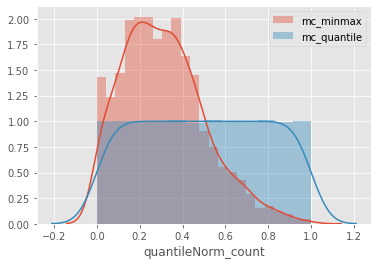

In [84]:
import seaborn as sns
sns.distplot(CBD_MonteCarloSim.MinMaxNorm_count, label='mc_minmax', kde=True)
sns.distplot(CBD_MonteCarloSim.quantileNorm_count, label='mc_quantile', kde=True)
# sns.distplot(CBD_CTGAN.MinMaxNorm_count, label='ctgan_minmax', kde=True)
# sns.distplot(CBD_CTGAN.quantileNorm_count, label='ctgan_quantile', kde=True)
plt.legend()

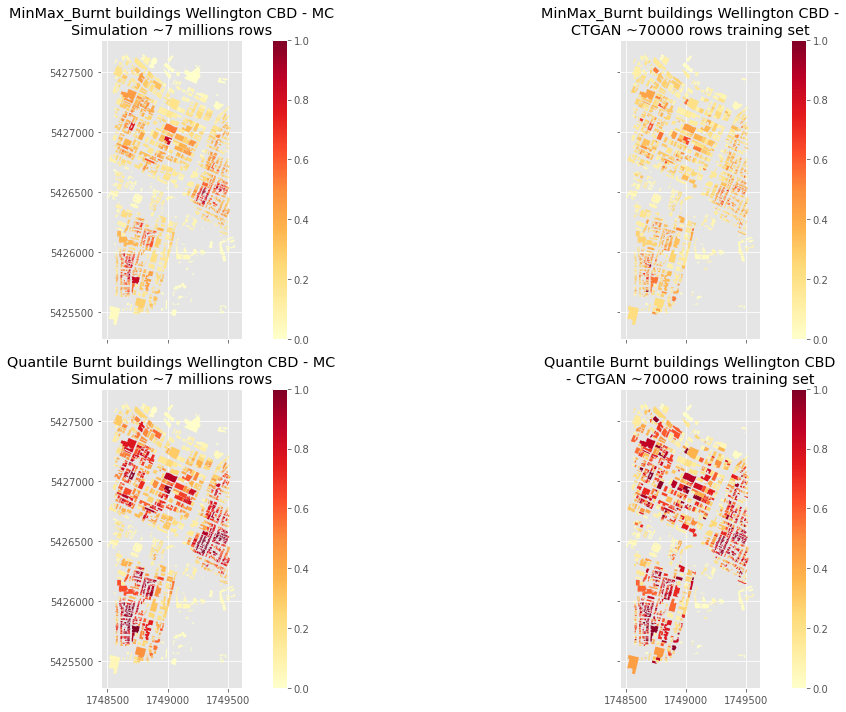

In [90]:
# plot
# sns.set(style="ticks", color_codes=True)
plt.style.use('ggplot')
fig, ((ax1, ax2), (ax1b, ax2b)) = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(16, 10))
CBD_MonteCarloSim.plot(ax=ax1, column='MinMaxNorm_count', cmap='YlOrRd', legend=True)
CBD_CTGAN.plot(ax=ax2, column='MinMaxNorm_count', cmap='YlOrRd', legend=True)
CBD_MonteCarloSim.plot(ax=ax1b, column='quantileNorm_count', cmap='YlOrRd', legend=True)
CBD_CTGAN.plot(ax=ax2b, column='quantileNorm_count', cmap='YlOrRd', legend=True)
ax1.set_title("\n".join(wrap('MinMax_Burnt buildings Wellington CBD - MC Simulation ~7 millions rows', 45)))
ax1.ticklabel_format(useOffset=False, style='plain')
ax2.set_title("\n".join(wrap('MinMax_Burnt buildings Wellington CBD - CTGAN ~70000 rows training set', 40)))
ax2.ticklabel_format(useOffset=False, style='plain')
ax1b.set_title("\n".join(wrap('Quantile Burnt buildings Wellington CBD - MC Simulation ~7 millions rows', 45)))
ax1b.ticklabel_format(useOffset=False, style='plain')
ax2b.set_title("\n".join(wrap('Quantile Burnt buildings Wellington CBD - CTGAN ~70000 rows training set', 40)))
ax2b.ticklabel_format(useOffset=False, style='plain')
plt.tight_layout()
fig.savefig(pathCTGANoutput / 'comparisonCBD_normalized_map.jpg', dpi=300)

In [0]:
CBD_MonteCarloSim.info()

In [0]:
CBD_CTGAN.info()

In [0]:
CBD_CTGAN.describe()

In [0]:
CBD_MonteCarloSim_crop.describe()

###**plots**

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


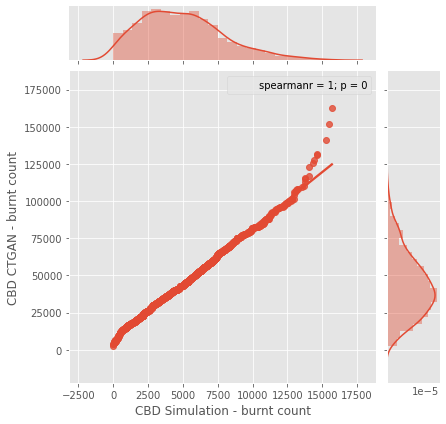

In [92]:
import seaborn as sns
import scipy.stats as stats

plt.style.use('ggplot')
CBD_MonteCarloSim_crop = CBD_MonteCarloSim[CBD_MonteCarloSim['source'].isin(CBD_CTGAN['source'])]
j = sns.jointplot(CBD_MonteCarloSim_crop['count'], CBD_CTGAN['count'], kind='reg', height=6).set_axis_labels('CBD Simulation - burnt count', 'CBD CTGAN - burnt count')
j.annotate(stats.pearsonr)
j.annotate(stats.spearmanr)
j.savefig(pathCTGANoutput / 'comparisonCBD_plot.jpg', dpi=300)

Create plot for Wellington region


*   Left - Wellington region, Monte Carlo 500M rows
*   Right - Wellington region, CTGAN 7M rows from CBD 70000 rows



In [0]:
# region_MonteCarloSim = gpd.read_file('/content/drive/My Drive/04_Cloud/01_Work/GNS/008_FFE/runs/results/burned_buildings.shp')
# region_MonteCarloSim["count"] = pd.to_numeric(region_MonteCarloSim["count"])
# region_CTGAN = merge_coordinates_export_shape(count_df, gdfRegion, "Regional_SyntheticCTGANmapBurnedBuildings")
# # plot
# fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(14, 8))
# region_MonteCarloSim.plot(ax=ax1, column='count', cmap='seismic', legend=True, )
# region_CTGAN.plot(ax=ax2, column='count', cmap='seismic', legend=True)
# ax1.set_title(' Burnt building Wellington Region - MC Simulation ~530 millions rows')
# ax1.ticklabel_format(useOffset=False, style='plain')
# ax2.set_title(' Burnt building Wellington Region - CTGAN ~70000 rows training set')
# ax2.ticklabel_format(useOffset=False, style='plain')
# plt.tight_layout()
# fig.savefig(pathCTGANoutput / 'comparisonRegion.jpg', dpi=300)